In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import h5py

%matplotlib inline

In [2]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [3]:
def conv2d(X, W):
    return tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(X):
    return tf.nn.max_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [4]:
batch_size = 50
n_epochs = 10

In [5]:
f = h5py.File("cropfield.hdf5", "r")
train_dataset = f["train_dataset"][...]
train_labels = f["train_labels"][...]
valid_dataset = f["valid_dataset"][...]
valid_labels = f["valid_labels"][...]
f.close()

In [6]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
CHANNEL = 3
NUM_LABELS = 3

def reformat(dataset, labels):
    if dataset.shape[1:] != (IMAGE_WIDTH, IMAGE_HEIGHT, CHANNEL):
        dataset = dataset.reshape((-1, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNEL)).astype(np.float32)
    labels = (np.arange(NUM_LABELS) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
#test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
#print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (18000, 256, 256, 3), (18000, 3))
('Validation set', (3000, 256, 256, 3), (3000, 3))


In [7]:
X = tf.placeholder(tf.float32, [None, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNEL], name='X_placeholder')
Y = tf.placeholder(tf.int32, [None, NUM_LABELS], name='Y_placeholder')

In [8]:
W_conv1 = weight_variable([5, 5, 3, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(X, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [9]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [10]:
W_fc1 = weight_variable([64 * 64 * 64, 512])
b_fc1 = bias_variable([512])

h_pool2_flat = tf.reshape(h_pool2, [-1, 64*64*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [11]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [12]:
W_fc2 = weight_variable([512, 3])
b_fc2 = bias_variable([3])

Y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [13]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=Y_conv))
optimizer = tf.train.GradientDescentOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(Y_conv, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
loss_list = []

In [15]:
start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n_batches = int(18000/batch_size)
    for i in xrange(n_epochs):
        for j in xrange(n_batches):
            X_batch = train_dataset[j*batch_size:(j*batch_size+batch_size)]
            Y_batch = train_labels[j*batch_size:(j*batch_size+batch_size)]
            train_accuracy = accuracy.eval(feed_dict={X: X_batch, Y: Y_batch, keep_prob: 1.0})
            print "Epoch {0}, batch {1}, accuracy: {2}".format(i, j, train_accuracy)
            _, loss_batch = sess.run([optimizer, cross_entropy], feed_dict={X: X_batch, Y: Y_batch, keep_prob: 0.5})
            loss_list.append(loss_batch)
    
    n_batches_test = int(3000/batch_size)
    accuracies = []
    for j in xrange(n_batches_test):
        X_batch = valid_dataset[j*batch_size:(j*batch_size+batch_size)]
        Y_batch = valid_labels[j*batch_size:(j*batch_size+batch_size)]
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, Y: Y_batch, keep_prob: 1.0})
        print 'Test accuracy batch {0}: {1}'.format(j, accuracy_val)
        accuracies.append(accuracy_val)
    print 'Test accuracy: {}'.format(np.mean(accuracies))
end_time = time.time()

Epoch 0, batch 0, accuracy: 0.259999990463
Epoch 0, batch 1, accuracy: 0.40000000596
Epoch 0, batch 2, accuracy: 0.40000000596
Epoch 0, batch 3, accuracy: 0.319999992847
Epoch 0, batch 4, accuracy: 0.479999989271
Epoch 0, batch 5, accuracy: 0.460000008345
Epoch 0, batch 6, accuracy: 0.379999995232
Epoch 0, batch 7, accuracy: 0.439999997616
Epoch 0, batch 8, accuracy: 0.319999992847
Epoch 0, batch 9, accuracy: 0.379999995232
Epoch 0, batch 10, accuracy: 0.219999998808
Epoch 0, batch 11, accuracy: 0.439999997616
Epoch 0, batch 12, accuracy: 0.340000003576
Epoch 0, batch 13, accuracy: 0.540000021458
Epoch 0, batch 14, accuracy: 0.460000008345
Epoch 0, batch 15, accuracy: 0.479999989271
Epoch 0, batch 16, accuracy: 0.379999995232
Epoch 0, batch 17, accuracy: 0.40000000596
Epoch 0, batch 18, accuracy: 0.460000008345
Epoch 0, batch 19, accuracy: 0.660000026226
Epoch 0, batch 20, accuracy: 0.579999983311
Epoch 0, batch 21, accuracy: 0.560000002384
Epoch 0, batch 22, accuracy: 0.600000023842
E

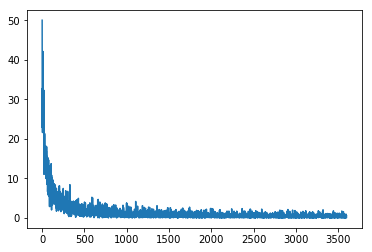

In [16]:
plt.plot(loss_list)
plt.show()

In [18]:
execute_time = (end_time - start_time) / 3600
print execute_time

25.9848266308
